# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [0]:
# Run some setup code for this notebook.

import random
import numpy as np
from assignment1.cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Assignment

In [0]:
!wget --header="Host: cs231n.github.io" --header="User-Agent: Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.119 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://cs231n.github.io/assignments2018/assignment1/" --header="Cookie: _ga=GA1.3.210319331.1551607788; _gid=GA1.3.1141866968.1551607788; _gat=1" --header="Connection: keep-alive" "http://cs231n.github.io/assignments/2018/spring1718_assignment1.zip" -O "spring1718_assignment1.zip" -c

--2019-03-13 14:59:30--  http://cs231n.github.io/assignments/2018/spring1718_assignment1.zip
Resolving cs231n.github.io (cs231n.github.io)... 185.199.111.153, 185.199.108.153, 185.199.110.153, ...
Connecting to cs231n.github.io (cs231n.github.io)|185.199.111.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73256 (72K) [application/zip]
Saving to: ‘spring1718_assignment1.zip’

spring1718_assignme 100%[===================>]  71.54K  --.-KB/s    in 0.02s   

2019-03-13 14:59:30 (2.88 MB/s) - ‘spring1718_assignment1.zip’ saved [73256/73256]



In [0]:
!unzip -qq spring1718_assignment1.zip

In [0]:
%%bash
cd assignment1
cd cs231n
cd datasets
./get_datasets.sh

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


--2019-03-13 14:59:35--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  138K 20m6s
    50K .......... .......... .......... .......... ..........  0%  278K 15m2s
   100K .......... .......... .......... .......... ..........  0% 12.7M 10m6s
   150K .......... .......... .......... .......... ..........  0% 15.1M 7m37s
   200K .......... .......... .......... .......... ..........  0%  283K 8m3s
   250K .......... .......... .......... .......... ..........  0% 20.7M 6m44s
   300K .......... .......... .......... .......... ..........  0% 17.5M 5m47s
   350K .......... .......... .......... .......... ..........  0% 21.4M 5m5s
   400K .

## CIFAR-10 Data Loading and Preprocessing

In [0]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'assignment1/cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


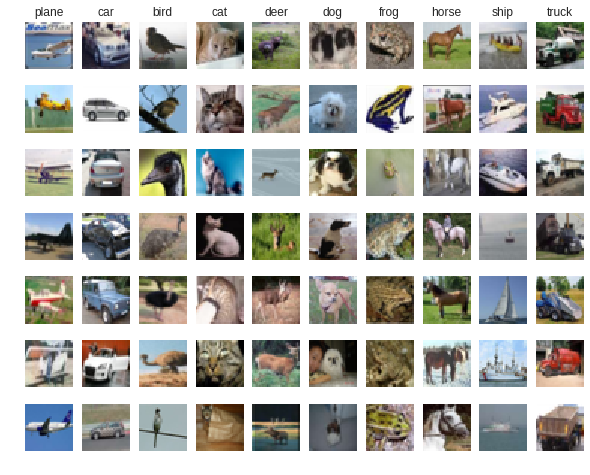

In [0]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [0]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [0]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


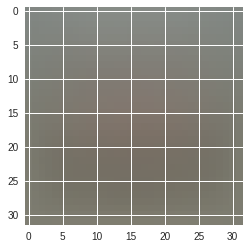

In [0]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [0]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [0]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


***Assignment Implementation***

In [0]:
def L_i(x, y, W):
  """
  unvectorized version. Compute the multiclass svm loss for a single example (x,y)
  - x is a column vector representing an image (e.g. 3073 x 1 in CIFAR-10)
    with an appended bias dimension in the 3073-rd position (i.e. bias trick)
  - y is an integer giving index of correct class (e.g. between 0 and 9 in CIFAR-10)
  - W is the weight matrix (e.g. 10 x 3073 in CIFAR-10)
  """
  delta = 1.0 # see notes about delta later in this section
  scores = W.dot(x) # scores becomes of size 10 x 1, the scores for each class
  correct_class_score = scores[y]
  D = W.shape[0] # number of classes, e.g. 10
  loss_i = 0.0
  for j in range(D): # iterate over all wrong classes
    if j == y:
      # skip for the true class to only loop over incorrect classes
      continue
    # accumulate loss for the i-th example
    loss_i += max(0, scores[j] - correct_class_score + delta)
  return loss_i

def L_i_vectorized(x, y, W):
  """
  A faster half-vectorized implementation. half-vectorized
  refers to the fact that for a single example the implementation contains
  no for loops, but there is still one loop over the examples (outside this function)
  """
  delta = 1.0
  scores = W.dot(x)
  # compute the margins for all classes in one vector operation
  margins = np.maximum(0, scores - scores[y] + delta)
  # on y-th position scores[y] - scores[y] canceled and gave delta. We want
  # to ignore the y-th position and only consider margin on max wrong class
  margins[y] = 0
  loss_i = np.sum(margins)
  return loss_i

def L(X, y, W):
  """
  fully-vectorized implementation :
  - X holds all the training examples as columns (e.g. 3073 x 50,000 in CIFAR-10)
  - y is array of integers specifying correct class (e.g. 50,000-D array)
  - W are weights (e.g. 10 x 3073)
  """
  num_train = X.shape[1]
  scores = W.dot(X)
  delta = 1.0
  score = scores.T
  correct_class_scores = score[range(num_train), y].reshape(-1, 1)
  margins = score - correct_class_scores + delta
  loss_i = margins.clip(min=0).sum() - num_train
  loss_i/= num_train

  return loss_i
  
  # evaluate loss over all examples in X without using any for loops
  # left as exercise to reader in the assignment

In [0]:
W = np.random.randn(10, 3073) * 0.0001 # generate random parameters
x = X_train.reshape(3073,-1)
loss = L(x, y_train, W)
print(loss)

9.035017092945289


In [0]:
#random search:
bestloss = float("inf") # Python assigns the highest possible float value
for num in range(1000):
  W = np.random.randn(10, 3073) * 0.0001 # generate random parameters
  loss = L(x, y_train, W) # get the loss over the entire training set
  if loss < bestloss: # keep track of the best solution
    bestloss = loss
    bestW = W
  print ('in attempt %d the loss was %f, best %f' % (num, loss, bestloss))

in attempt 0 the loss was 9.046126, best 9.046126
in attempt 1 the loss was 9.014324, best 9.014324
in attempt 2 the loss was 9.029715, best 9.014324
in attempt 3 the loss was 9.016790, best 9.014324
in attempt 4 the loss was 9.035991, best 9.014324
in attempt 5 the loss was 9.016851, best 9.014324
in attempt 6 the loss was 9.018011, best 9.014324
in attempt 7 the loss was 9.024088, best 9.014324
in attempt 8 the loss was 9.031007, best 9.014324
in attempt 9 the loss was 9.041398, best 9.014324
in attempt 10 the loss was 9.021087, best 9.014324
in attempt 11 the loss was 9.027921, best 9.014324
in attempt 12 the loss was 9.019294, best 9.014324
in attempt 13 the loss was 9.035507, best 9.014324
in attempt 14 the loss was 9.041346, best 9.014324
in attempt 15 the loss was 9.021018, best 9.014324
in attempt 16 the loss was 9.047759, best 9.014324
in attempt 17 the loss was 9.035934, best 9.014324
in attempt 18 the loss was 9.039255, best 9.014324
in attempt 19 the loss was 9.007424, best

In [0]:
#accuracy using random search
# Assume X_test is [3073 x 10000], Y_test [10000 x 1]
Xte_cols = X_test.reshape(3073,-1)
scores = bestW.dot(Xte_cols) # 10 x 10000, the class scores for all test examples
# find the index with max score in each column (the predicted class)
Yte_predict = np.argmax(scores, axis = 0)
# and calculate accuracy (fraction of predictions that are correct)
np.mean(Yte_predict == y_test)
# returns 0.1555

0.09

In [0]:
#random local search
W = np.random.randn(10, 3073) * 0.001 # generate random starting W
bestloss = float("inf")
for i in range(1000):
  step_size = 0.0001
  Wtry = W + np.random.randn(10, 3073) * step_size
  loss = L(x, y_train, Wtry)
  if loss < bestloss:
    W = Wtry
    bestloss = loss
  print ('iter %d loss is %f' % (i, bestloss))

iter 0 loss is 23.066289
iter 1 loss is 23.066289
iter 2 loss is 23.066289
iter 3 loss is 23.066289
iter 4 loss is 23.066289
iter 5 loss is 23.053066
iter 6 loss is 23.053066
iter 7 loss is 23.053066
iter 8 loss is 23.053066
iter 9 loss is 23.053066
iter 10 loss is 23.053066
iter 11 loss is 23.053066
iter 12 loss is 23.053066
iter 13 loss is 23.053066
iter 14 loss is 23.053066
iter 15 loss is 23.053066
iter 16 loss is 23.053066
iter 17 loss is 23.053066
iter 18 loss is 23.053066
iter 19 loss is 23.053066
iter 20 loss is 23.053066
iter 21 loss is 23.053066
iter 22 loss is 23.053066
iter 23 loss is 23.053066
iter 24 loss is 23.053066
iter 25 loss is 23.053066
iter 26 loss is 23.053066
iter 27 loss is 23.037111
iter 28 loss is 23.037111
iter 29 loss is 23.037111
iter 30 loss is 23.037111
iter 31 loss is 23.037111
iter 32 loss is 23.037111
iter 33 loss is 23.037111
iter 34 loss is 23.037111
iter 35 loss is 23.013584
iter 36 loss is 23.013584
iter 37 loss is 23.013584
iter 38 loss is 23.013

In [0]:
def eval_numerical_gradient(f, x):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros(x.shape)
  h = 0.00001

  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    old_value = x[ix]
    x[ix] = old_value + h # increment by h
    fxh = f(x) # evalute f(x + h)
    x[ix] = old_value # restore to previous value (very important!)

    # compute the partial derivative
    grad[ix] = (fxh - fx) / h # the slope
    it.iternext() # step to next dimension

  return grad

In [0]:
def CIFAR10_loss_fn(W):
  return L(x, y_train, W)

KeyboardInterrupt: ignored

In [0]:

W = np.random.rand(10, 3073) * 0.001 # random weight vector

df = eval_numerical_gradient(CIFAR10_loss_fn, W)

KeyboardInterrupt: ignored

In [0]:
loss_original = CIFAR10_loss_fun(W) # the original loss
print 'original loss: %f' % (loss_original, )

# lets see the effect of multiple step sizes
for step_size_log in [-10, -9, -8, -7, -6, -5,-4,-3,-2,-1]:
  step_size = 10 ** step_size_log
  W_new = W - step_size * df # new position in the weight space
  loss_new = CIFAR10_loss_fun(W_new)
  print 'for step size %f new loss: %f' % (step_size, loss_new)

-------------------------------------------------------------------------------------------------------------------

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [0]:
#linear_svm
import numpy as np


def svm_loss_naive(w, x, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.
    :param w: A numpy array of shape (D, C) containing weights.
    :param x: A numpy array of shape (N, D) containing a mini-batch of data.
    :param y: A numpy array of shape (N,) containing training labels; y[i] = c means
              that x[i] has label c, where 0 <= c < C.
    :param reg: (float) regularization strength
    :return: Returns a tuple of:
             - loss as single float
             - gradient with respect to weights W; an array of same shape as W
    """

    dw = np.zeros(w.shape)  # initialize the gradient as zero

    # compute the loss and the gradient
    num_classes = w.shape[1]
    num_train = x.shape[0]
    loss = 0.0
    for i in range(num_train):
        scores = x[i].dot(w)
        correct_class_score = scores[y[i]]
        # we'll count the number of classes that didn’t meet the desired margin
        num_positive_margin = 0
      
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1  # note delta = 1
            if margin > 0:
                loss += margin
                # if the current class does't meet the desired margin, remember it
                num_positive_margin += 1
                # if the current class does't meet the desired margin, increment the gradient w.r.t.
                # to the current incorrect class by X_i
                dw[:, j] += x[i, :]
        # decrement the gradient w.r.t. to the correct class by X_i times the number of times other
        # classes didn’t meet the desired margin
        dw[:, y[i]] -= num_positive_margin * x[i, :]

    # Right now the loss is a sum over all training examples, but we want it
    # to be an average instead so we divide by num_train.
    loss /= num_train
    dw /= num_train

    # Add regularization to the loss.
    loss += reg * np.sum(w * w)
    dw += 2 * reg * w

    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather that first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################

    return loss, dw


def svm_loss_vectorized(w, x, y, reg):
    """
    Structured SVM loss function, vectorized implementation.
    Inputs and outputs are the same as svm_loss_naive.
    """
    num_train = x.shape[0]
    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    # shape (num_train, num_classes)
    scores = x.dot(w)
    # select in each row i the score at position y[i]
    correct_class_scores = scores[range(num_train), y].reshape(-1, 1)
    # compute margins row-wise, shape (num_train, num_classes)
    margins = scores - correct_class_scores + 1
    # compute SVM loss
    loss = margins.clip(min=0).sum() - num_train
    loss /= num_train
    loss += reg * np.sum(w * w)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################

    # where the margins are positive, shape (num_train, num_classes)
    idx_positive_margins = np.greater(margins, 0).astype('int')
    # for each object and correct class substract the number of positive margins
    idx_positive_margins[range(num_train), y] -= idx_positive_margins.sum(axis=1)
    # multiple X transposed by the previous matrix
    dw = x.T.dot(idx_positive_margins)
    dw /= num_train
    dw += 2 * reg * w
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return loss, dw

In [0]:
# Evaluate the naive implementation of the loss we provided for you:
#from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.033330


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [0]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from assignment1.cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -3.433731 analytic: -3.433731, relative error: 7.127918e-11
numerical: -8.251285 analytic: -8.251285, relative error: 1.149598e-11
numerical: 30.502599 analytic: 30.502599, relative error: 5.236953e-12
numerical: 7.887169 analytic: 7.887169, relative error: 4.648259e-11
numerical: 2.276812 analytic: 2.276812, relative error: 2.511211e-10
numerical: 10.650245 analytic: 10.650245, relative error: 4.493312e-11
numerical: -3.595850 analytic: -3.595850, relative error: 4.028357e-11
numerical: -14.586848 analytic: -14.572717, relative error: 4.846367e-04
numerical: 4.263769 analytic: 4.263769, relative error: 3.840809e-11
numerical: 14.422904 analytic: 14.422904, relative error: 1.046879e-15
numerical: -10.467224 analytic: -10.467224, relative error: 1.287734e-12
numerical: 3.532607 analytic: 3.532607, relative error: 1.525806e-10
numerical: 15.178237 analytic: 15.178237, relative error: 1.277358e-12
numerical: 28.504665 analytic: 28.504665, relative error: 2.340544e-12
numerical:

In [0]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

#from assignment1.cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.033330e+00 computed in 0.136541s
Vectorized loss: 9.033330e+00 computed in 0.012174s
difference: 0.000000


In [0]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.142687s
Vectorized loss and gradient: computed in 0.011517s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [0]:
#linear_classifier.py
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, x, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.
        :param x: A numpy array of shape (N, D) containing training data; there are N
                  training samples each of dimension D.
        :param y: A numpy array of shape (N,) containing training labels; y[i] = c
                  means that X[i] has label 0 <= c < C for C classes.
        :param learning_rate: (float) learning rate for optimization.
        :param reg: (float) regularization strength.
        :param num_iters: (integer) number of steps to take when optimizing
        :param batch_size: (integer) number of training examples to use at each step.
        :param verbose: (boolean) If true, print progress during optimization.
        :return loss_history: A list containing the value of the loss function at each training iteration.
        """

        num_train, dim = x.shape
        num_classes = np.max(y) + 1  # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []

        for it in range(num_iters):
            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            idx = np.random.choice(range(x.shape[0]), size=batch_size)
            x_batch, y_batch = x[idx, :], y[idx]
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            # evaluate loss and gradient
            loss, grad = self.loss(x_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO: Update the weights using the gradient and the learning rate.    #
            #########################################################################
            self.W -= learning_rate * grad
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, x):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.
        :param x: A numpy array of shape (N, D) containing training data; there are N
                  training samples each of dimension D.
        :return y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
                        array of length N, and each element is an integer giving the
                        predicted class.
        """
        ###########################################################################
        # TODO: Implement this method. Store the predicted labels in y_pred.      #
        ###########################################################################
        y_pred = np.argmax(x.dot(self.W), axis=1)
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred

    def loss(self, x_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.
        :param x_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        :param y_batch: A numpy array of shape (N,) containing labels for the mini-batch.
        :param reg: (float) regularization strength.
        :return: A tuple containing:
                     - loss as a single float
                     - gradient with respect to self.W; an array of the same shape as W
        """
        pass


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, x_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, x_batch, y_batch, reg)


class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, x_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, x_batch, y_batch, reg)

In [0]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
#from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 793.290402
iteration 100 / 1500: loss 289.430703
iteration 200 / 1500: loss 108.172225
iteration 300 / 1500: loss 42.604736
iteration 400 / 1500: loss 19.140974
iteration 500 / 1500: loss 10.456656
iteration 600 / 1500: loss 7.446054
iteration 700 / 1500: loss 6.363242
iteration 800 / 1500: loss 5.458088
iteration 900 / 1500: loss 5.765879
iteration 1000 / 1500: loss 5.731159
iteration 1100 / 1500: loss 4.985555
iteration 1200 / 1500: loss 5.421868
iteration 1300 / 1500: loss 4.823434
iteration 1400 / 1500: loss 5.452545
That took 25.976552s


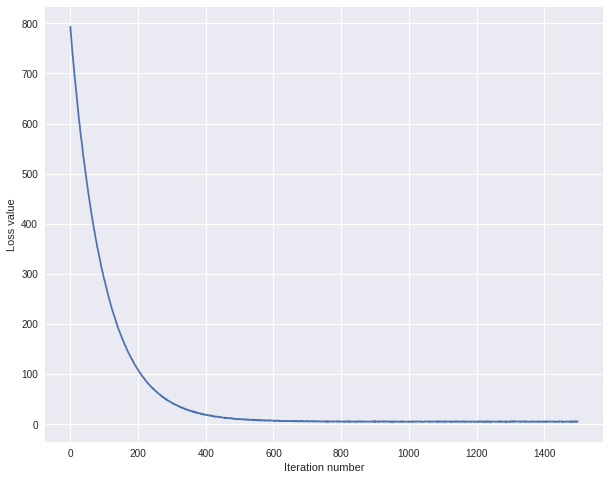

In [0]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [0]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.363551
validation accuracy: 0.364000


In [0]:
%%time

from tqdm import tqdm_notebook

# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = np.linspace(1.5e-7, 3e-7, 10)
regularization_strengths = np.linspace(0.5e3, 2e4, 10)

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in tqdm_notebook(learning_rates):
    for reg in tqdm_notebook(regularization_strengths):
        svm = LinearSVM()
        _ = svm.train(X_train, y_train, learning_rate=lr, 
                      reg=reg,
                      num_iters=1500, verbose=False)
        y_train_pred = svm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


lr 1.500000e-07 reg 5.000000e+02 train accuracy: 0.327429 val accuracy: 0.331000
lr 1.500000e-07 reg 2.666667e+03 train accuracy: 0.369959 val accuracy: 0.360000
lr 1.500000e-07 reg 4.833333e+03 train accuracy: 0.388061 val accuracy: 0.373000
lr 1.500000e-07 reg 7.000000e+03 train accuracy: 0.383429 val accuracy: 0.382000
lr 1.500000e-07 reg 9.166667e+03 train accuracy: 0.379735 val accuracy: 0.384000
lr 1.500000e-07 reg 1.133333e+04 train accuracy: 0.382755 val accuracy: 0.377000
lr 1.500000e-07 reg 1.350000e+04 train accuracy: 0.380000 val accuracy: 0.388000
lr 1.500000e-07 reg 1.566667e+04 train accuracy: 0.378245 val accuracy: 0.392000
lr 1.500000e-07 reg 1.783333e+04 train accuracy: 0.367816 val accuracy: 0.383000
lr 1.500000e-07 reg 2.000000e+04 train accuracy: 0.371388 val accuracy: 0.391000
lr 1.666667e-07 reg 5.000000e+02 train accuracy: 0.330837 val accuracy: 0.344000
lr 1.666667e-07 reg 2.666667e+03 train accuracy: 0.383143 val accuracy: 0.370000
lr 1.666667e-07 reg 4.83333

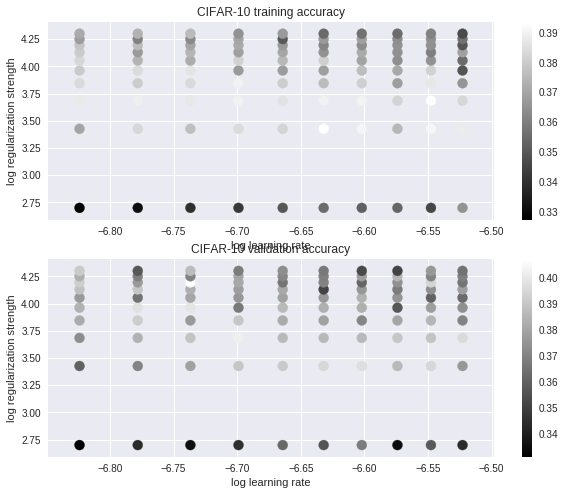

In [0]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [0]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.364000


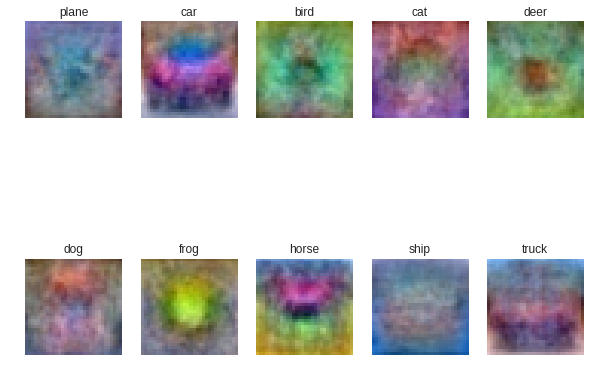

In [0]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])